In [1]:
# Importing Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import os
import h5py
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [ ]:
# Loading and Extracting HDF5 Files
data_paths = {
    'electron_data': "/teamspace/studios/this_studio/common task/data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5",
    'photon_data': "/teamspace/studios/this_studio/common task/data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
}
# Initializing datasets
electron_images, photon_images = None, None
# Iterating over the dictionary to load data
for particle_type, file_path in data_paths.items():
    try:
        with h5py.File(file_path, "r") as data_file:
            dataset_name = list(data_file.keys())[0]
            particle_data = data_file[dataset_name][:]
            
            # Storing data
            if particle_type == 'electron_data':
                electron_images = particle_data
            elif particle_type == 'photon_data':
                photon_images = particle_data
            
    except Exception as error:
        print(f"Error reading {particle_type}: {error}")
# Printing shapes to verify data loading was successful
print("Electron data shape:", electron_images.shape if electron_images is not None else "Not loaded")
print("Photon data shape:", photon_images.shape if photon_images is not None else "Not loaded")


Electron data shape: (249000, 32, 32, 2)
Photon data shape: (249000, 32, 32, 2)


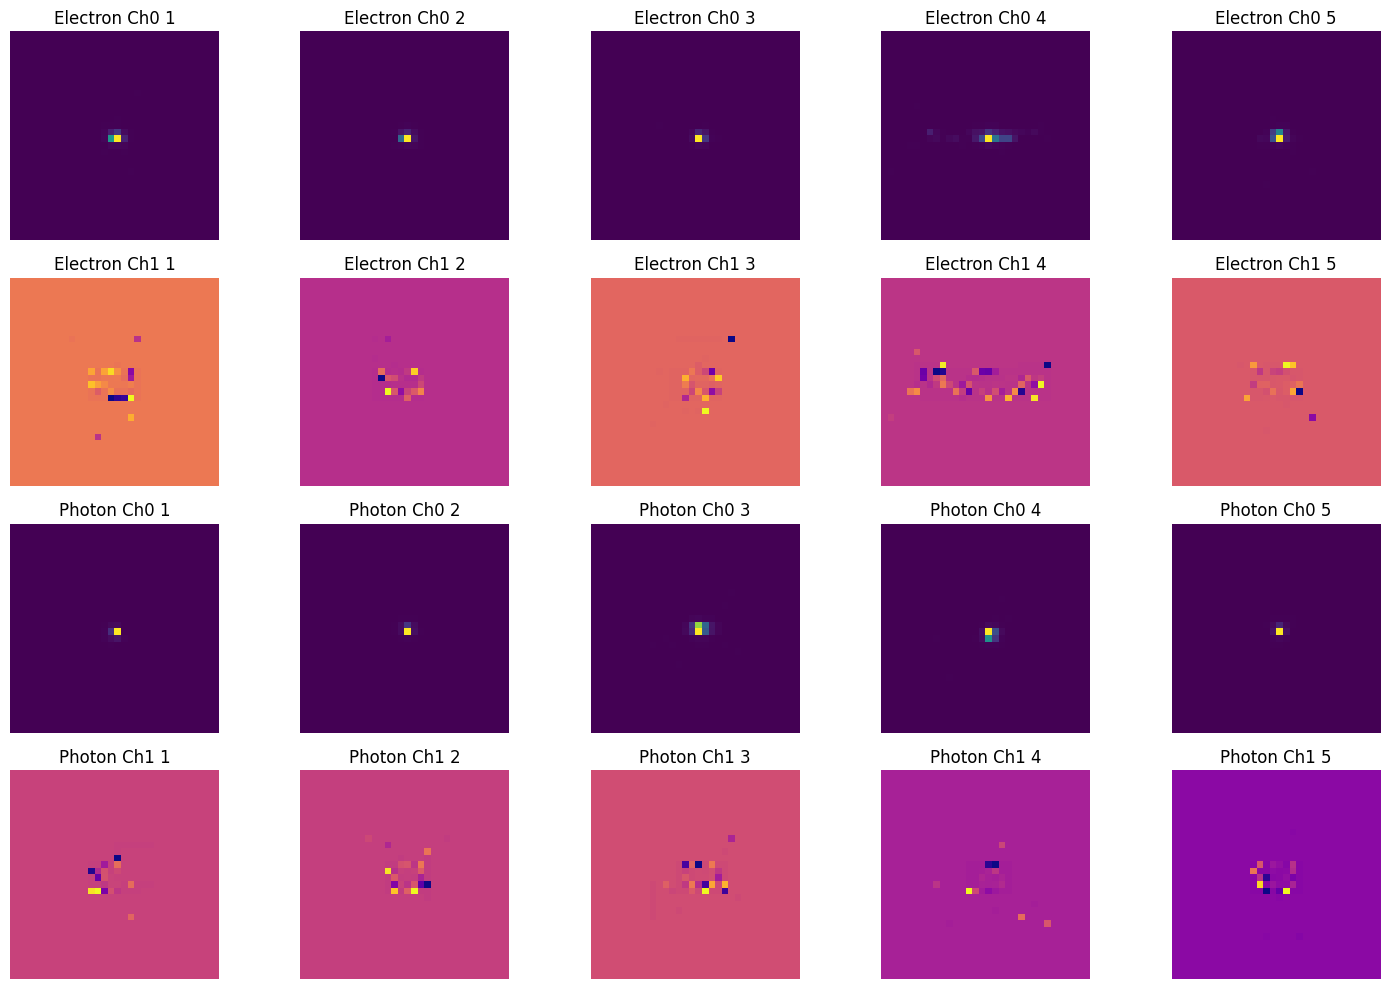

In [ ]:
# Enhanced Data Visualization
# I'm creating more detailed visualizations to better understand the data
# Function to normalize images for better visualization
def normalize_for_display(image_data):
    """Normalize image data to improve visibility"""
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    if max_val == min_val:
        return np.zeros_like(image_data)
    return (image_data - min_val) / (max_val - min_val)
# 1. Sample Images Visualization with normalization
# Randomly selecting 5 samples from each dataset
electron_samples = electron_images[np.random.choice(electron_images.shape[0], 5, replace=False)]
photon_samples = photon_images[np.random.choice(photon_images.shape[0], 5, replace=False)]
# Creating a figure with more rows to show each channel separately
fig, axes = plt.subplots(4, 5, figsize=(15, 10))  # 4 rows, 5 columns
# Displaying electron images - Channel 0
for i in range(5):
    norm_img = normalize_for_display(electron_samples[i, :, :, 0])
    axes[0, i].imshow(norm_img, cmap='viridis')
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Electron Ch0 {i+1}")
# Displaying electron images - Channel 1
for i in range(5):
    norm_img = normalize_for_display(electron_samples[i, :, :, 1])
    axes[1, i].imshow(norm_img, cmap='plasma')
    axes[1, i].axis("off")
    axes[1, i].set_title(f"Electron Ch1 {i+1}")
# Displaying photon images - Channel 0
for i in range(5):
    norm_img = normalize_for_display(photon_samples[i, :, :, 0])
    axes[2, i].imshow(norm_img, cmap='viridis')
    axes[2, i].axis("off")
    axes[2, i].set_title(f"Photon Ch0 {i+1}")
# Displaying photon images - Channel 1
for i in range(5):
    norm_img = normalize_for_display(photon_samples[i, :, :, 1])
    axes[3, i].imshow(norm_img, cmap='plasma')
    axes[3, i].axis("off")
    axes[3, i].set_title(f"Photon Ch1 {i+1}")
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

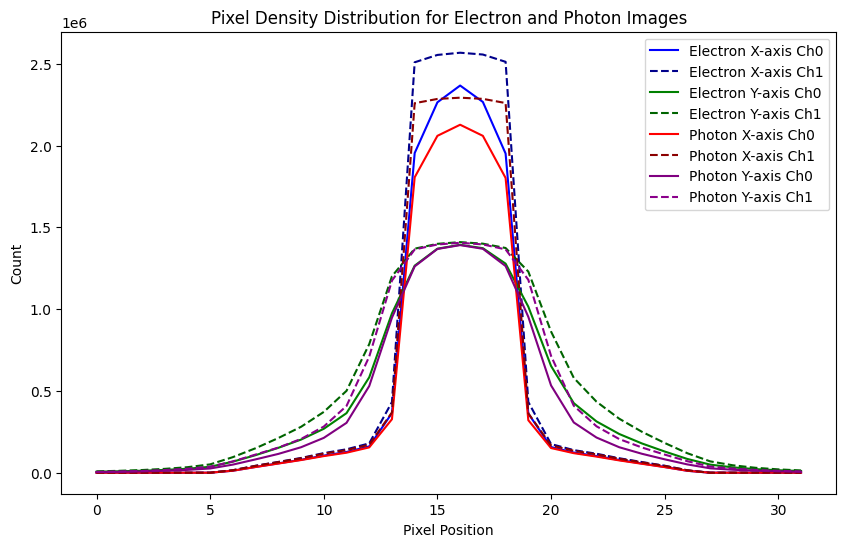

In [ ]:
# Pixel Distribution Analysis
# Creating binary masks to analyze pixel distributions
# I'm examining where data is concentrated in the images
electron_mask = np.zeros_like(electron_images)
electron_mask[np.where(electron_images != 0)] = 1
electron_y_sum = electron_mask.sum(0).sum(0)  # Sum along y-axis
electron_x_sum = electron_mask.sum(0).sum(1)  # Sum along x-axis
photon_mask = np.zeros_like(photon_images)
photon_mask[np.where(photon_images != 0)] = 1
photon_y_sum = photon_mask.sum(0).sum(0)  # Sum along y-axis
photon_x_sum = photon_mask.sum(0).sum(1)  # Sum along x-axis
# Plotting density distributions
plt.figure(figsize=(10, 6))
plt.plot(electron_x_sum[:, 0], label='Electron X-axis Ch0', linestyle='-', color='blue')
plt.plot(electron_x_sum[:, 1], label='Electron X-axis Ch1', linestyle='--', color='darkblue')
plt.plot(electron_y_sum[:, 0], label='Electron Y-axis Ch0', linestyle='-', color='green')
plt.plot(electron_y_sum[:, 1], label='Electron Y-axis Ch1', linestyle='--', color='darkgreen')
plt.plot(photon_x_sum[:, 0], label='Photon X-axis Ch0', linestyle='-', color='red')
plt.plot(photon_x_sum[:, 1], label='Photon X-axis Ch1', linestyle='--', color='darkred')
plt.plot(photon_y_sum[:, 0], label='Photon Y-axis Ch0', linestyle='-', color='purple')
plt.plot(photon_y_sum[:, 1], label='Photon Y-axis Ch1', linestyle='--', color='darkmagenta')
plt.title('Pixel Density Distribution for Electron and Photon Images')
plt.xlabel('Pixel Position')
plt.ylabel('Count')
plt.legend()
plt.savefig('pixel_density.png')
plt.show()

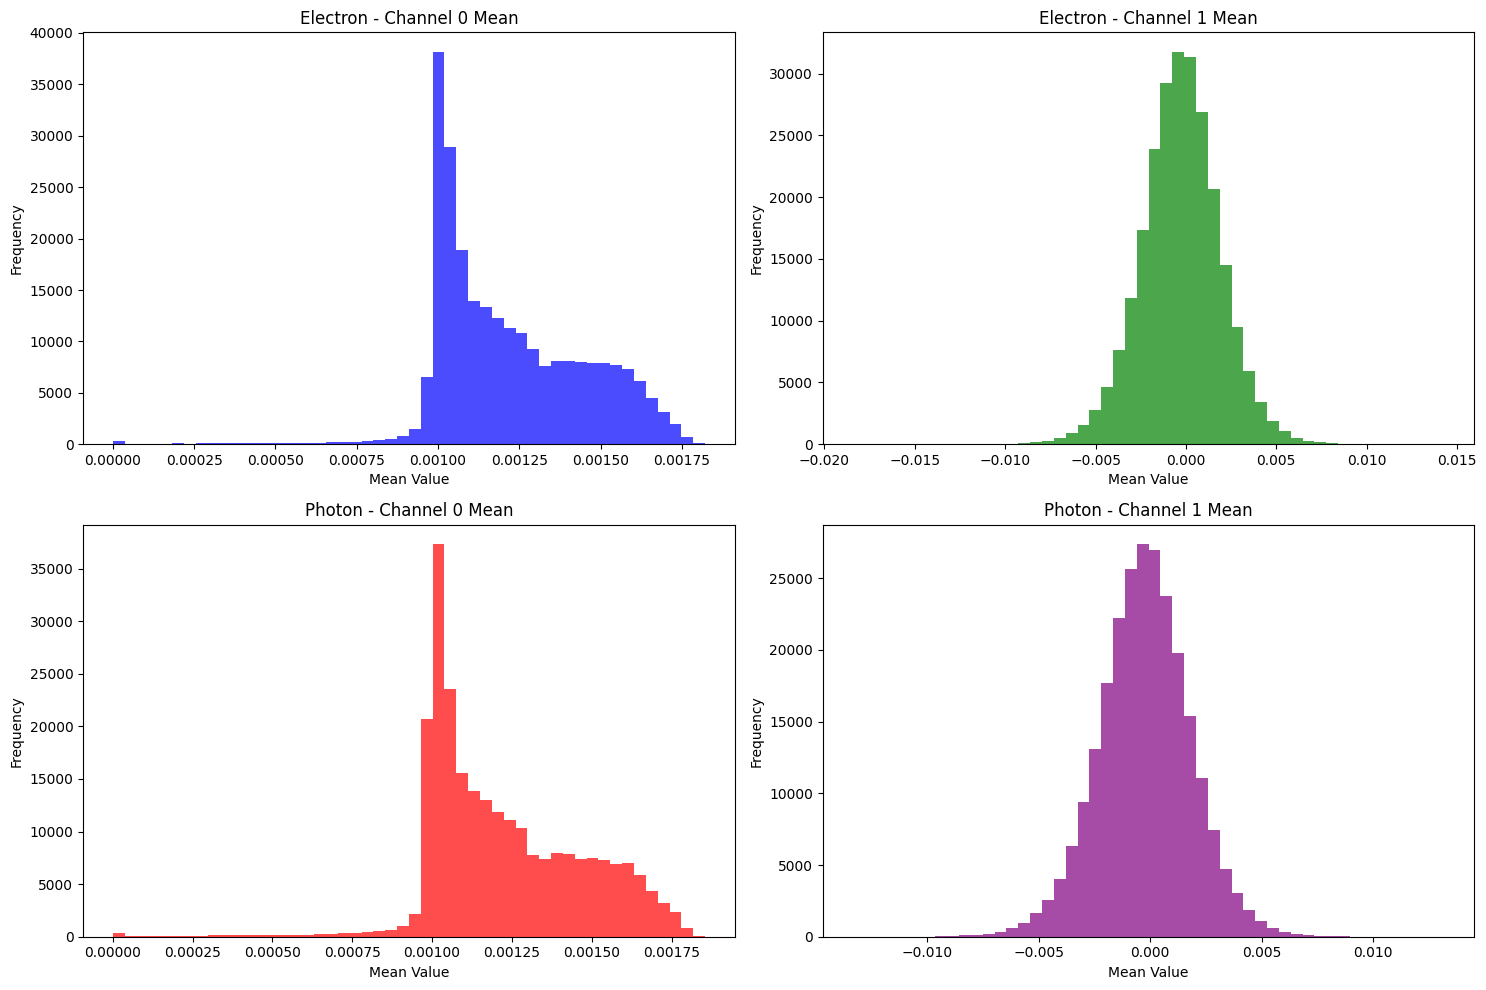

Electron Channel 0 - Min: 0.000000, Max: 0.001821, Mean: 0.001216, Std: 0.000231
Electron Channel 1 - Min: -0.018454, Max: 0.014323, Mean: -0.000287, Std: 0.002184
Photon Channel 0 - Min: 0.000000, Max: 0.001855, Mean: 0.001223, Std: 0.000243
Photon Channel 1 - Min: -0.013344, Max: 0.013207, Mean: -0.000237, Std: 0.002060


In [ ]:
# Statistical Analysis of Image Channels
# I'm analyzing the distribution of mean values to understand the data better
electron_ch0_mean = electron_images[:, :, :, 0].mean(axis=(1, 2))
electron_ch1_mean = electron_images[:, :, :, 1].mean(axis=(1, 2))
photon_ch0_mean = photon_images[:, :, :, 0].mean(axis=(1, 2))
photon_ch1_mean = photon_images[:, :, :, 1].mean(axis=(1, 2))
# Creating a figure for channel mean distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Plotting histograms of channel means
axes[0, 0].hist(electron_ch0_mean, bins=50, color='blue', alpha=0.7)
axes[0, 0].set_title("Electron - Channel 0 Mean")
axes[0, 0].set_xlabel("Mean Value")
axes[0, 0].set_ylabel("Frequency")

axes[0, 1].hist(electron_ch1_mean, bins=50, color='green', alpha=0.7)
axes[0, 1].set_title("Electron - Channel 1 Mean")
axes[0, 1].set_xlabel("Mean Value")
axes[0, 1].set_ylabel("Frequency")

axes[1, 0].hist(photon_ch0_mean, bins=50, color='red', alpha=0.7)
axes[1, 0].set_title("Photon - Channel 0 Mean")
axes[1, 0].set_xlabel("Mean Value")
axes[1, 0].set_ylabel("Frequency")

axes[1, 1].hist(photon_ch1_mean, bins=50, color='purple', alpha=0.7)
axes[1, 1].set_title("Photon - Channel 1 Mean")
axes[1, 1].set_xlabel("Mean Value")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig('channel_means.png')
plt.show()
# Printing some additional statistics
print("Electron Channel 0 - Min: {:.6f}, Max: {:.6f}, Mean: {:.6f}, Std: {:.6f}".format(
    np.min(electron_ch0_mean), np.max(electron_ch0_mean), 
    np.mean(electron_ch0_mean), np.std(electron_ch0_mean)))
print("Electron Channel 1 - Min: {:.6f}, Max: {:.6f}, Mean: {:.6f}, Std: {:.6f}".format(
    np.min(electron_ch1_mean), np.max(electron_ch1_mean), 
    np.mean(electron_ch1_mean), np.std(electron_ch1_mean)))
print("Photon Channel 0 - Min: {:.6f}, Max: {:.6f}, Mean: {:.6f}, Std: {:.6f}".format(
    np.min(photon_ch0_mean), np.max(photon_ch0_mean), 
    np.mean(photon_ch0_mean), np.std(photon_ch0_mean)))
print("Photon Channel 1 - Min: {:.6f}, Max: {:.6f}, Mean: {:.6f}, Std: {:.6f}".format(
    np.min(photon_ch1_mean), np.max(photon_ch1_mean), 
    np.mean(photon_ch1_mean), np.std(photon_ch1_mean)))

In [ ]:
# Preparation of Dataset & Dataloader
combined_images = np.concatenate((electron_images, photon_images), axis=0)
combined_labels = np.concatenate((np.zeros((electron_images.shape[0], 1)),
                                  np.ones((photon_images.shape[0], 1))), axis=0)
combined_images, combined_labels = shuffle(combined_images, combined_labels, random_state=42)
class ParticleDataset(Dataset):
    """Dataset class for particle classification task"""
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.len = self.images.shape[0] 

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        x = self.images[idx]
        y = self.labels[idx]
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)
        return x, y

# Splitting data into train/validation/test sets (80%/10%/10%) as mentioned in the task description
train_split = int(0.8 * len(combined_images))
val_split = int(0.9 * len(combined_images))
train_images, train_labels = combined_images[:train_split], combined_labels[:train_split]
val_images, val_labels = combined_images[train_split:val_split], combined_labels[train_split:val_split]
test_images, test_labels = combined_images[val_split:], combined_labels[val_split:]
# Creating datasets
train_dataset = ParticleDataset(train_images, train_labels)
val_dataset = ParticleDataset(val_images, val_labels)
test_dataset = ParticleDataset(test_images, test_labels)
# Creating data loaders
batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Training samples: 398400
Validation samples: 49800
Test samples: 49800


In [7]:
#  Model Construction
# I'm designing an efficient model with few parameters
class ConvBlock(nn.Module):
    """Basic convolutional block with batch norm and dropout"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, dropout_rate=0.2):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, 
                             padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x
class ParticleClassifier(nn.Module):
    """Efficient particle classifier with reduced parameters"""
    def __init__(self, num_classes=1):
        super(ParticleClassifier, self).__init__()
        
        # Initial convolution with larger kernel to capture spatial patterns
        self.conv1 = ConvBlock(2, 32, kernel_size=7, stride=2, dropout_rate=0.3)
        
        # Feature extraction layers
        self.conv2 = ConvBlock(32, 64, kernel_size=5, stride=2, dropout_rate=0.3)
        self.conv3 = ConvBlock(64, 128, kernel_size=3, stride=2, dropout_rate=0.3)
        self.conv4 = ConvBlock(128, 256, kernel_size=3, stride=1, dropout_rate=0.3)
        
        # Global pooling and classifier
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 64)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        if x.dim() == 4 and x.size(1) != 2:
            x = x.permute(0, 3, 1, 2)
        
        # Feature extraction
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        # Global pooling and classification
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [8]:
#Model Summary Function
# I'm creating a function to display the model architecture and parameter count
def display_model_summary(model, input_size=(1, 2, 32, 32)):
    """Display model architecture and calculate parameters"""
    model_copy = model
    print("Model Architecture:")
    print(model_copy)
    total_params = sum(p.numel() for p in model_copy.parameters())
    trainable_params = sum(p.numel() for p in model_copy.parameters() if p.requires_grad)
    
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Forward pass with dummy input to validate
    x = torch.zeros(input_size)
    try:
        _ = model_copy(x)
        print("\nForward pass successful with input shape:", input_size)
    except Exception as e:
        print(f"\nForward pass failed: {e}")
    
    return total_params, trainable_params

In [ ]:
# Initializing and Examining Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Creating model
particle_model = ParticleClassifier()
particle_model = particle_model.to(device)
# Displaying model summary
total_params, trainable_params = display_model_summary(particle_model)

Using device: cuda
Model Architecture:
ParticleClassifier(
  (conv1): ConvBlock(
    (conv): Conv2d(2, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (conv4): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:

# Training Setup
# I'm setting up the training components including loss function, optimizer, and scheduler
num_epochs = 100
learning_rate = 5e-4
weight_decay = 0.01  # L2 regularization
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(particle_model.parameters(), 
                            lr=learning_rate, 
                            weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                      T_max=num_epochs, 
                                                      eta_min=1e-6)
save_dir = "/teamspace/studios/this_studio/common task/models"
os.makedirs(save_dir, exist_ok=True)
print(f"Model will be saved to: {save_dir}")
# Initializing tracking variables for best model
best_val_acc = 0.0
best_model_path = os.path.join(save_dir, "best_particle_classifier.pth")
# Initializing lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

Model will be saved to: /teamspace/studios/this_studio/common task/models


In [14]:
#Training Function
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc="Training")
    for inputs, targets in progress_bar:
        inputs = inputs.to(device)
        inputs = inputs.permute(0, 3, 1, 2)  # Correct channel dimension
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Updating statistics
        running_loss += loss.item() * inputs.size(0)
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == targets).sum().item()
        total += targets.numel()
        
        # Updating progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{correct/total:.4f}"
        })
    
    # Calculating epoch statistics
    epoch_loss = running_loss / len(loader.dataset)
    epoch_accuracy = correct / total
    
    return epoch_loss, epoch_accuracy

In [12]:
#Validation Function
def validate(model, loader, criterion, device):
    """Validate model on validation set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Validation")
        for inputs, targets in progress_bar:
            inputs = inputs.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predictions == targets).sum().item()
            total += targets.numel()
            progress_bar.set_postfix({
                'val_loss': f"{loss.item():.4f}",
                'val_acc': f"{correct/total:.4f}"
            })
    epoch_loss = running_loss / len(loader.dataset)
    epoch_accuracy = correct / total
    
    return epoch_loss, epoch_accuracy

In [13]:
#Training Loop
# I'm implementing the main training loop with model checkpointing
print("Starting training...")

for epoch in range(num_epochs):
    # Training one epoch
    train_loss, train_acc = train_one_epoch(particle_model, train_loader, criterion, optimizer, device)
    
    # Validating
    val_loss, val_acc = validate(particle_model, val_loader, criterion, device)
    
    # Updating learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    
    # Storing metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    learning_rates.append(current_lr)
    
    # Printing epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
          f"LR: {current_lr:.6f}")
    
    # Saving best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(particle_model.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {val_acc:.4f}")
    
    # Saving checkpoint at every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(save_dir, f"particle_classifier_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': particle_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")
print("Training complete!")
print(f"Best validation accuracy: {best_val_acc:.4f}")

Starting training...


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.42it/s, val_loss=0.6534, val_acc=0.6197]


Epoch 1/100 - Train Loss: 0.6684, Train Acc: 0.5897, Val Loss: 0.6527, Val Acc: 0.6197, LR: 0.000500
New best model saved with validation accuracy: 0.6197


Validation: 100%|██████████| 25/25 [00:00<00:00, 28.77it/s, val_loss=0.6328, val_acc=0.6500]


Epoch 2/100 - Train Loss: 0.6529, Train Acc: 0.6189, Val Loss: 0.6304, Val Acc: 0.6500, LR: 0.000500
New best model saved with validation accuracy: 0.6500


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.09it/s, val_loss=0.6001, val_acc=0.6793]


Epoch 3/100 - Train Loss: 0.6259, Train Acc: 0.6570, Val Loss: 0.6067, Val Acc: 0.6793, LR: 0.000500
New best model saved with validation accuracy: 0.6793


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.49it/s, val_loss=0.6122, val_acc=0.6634]


Epoch 4/100 - Train Loss: 0.6127, Train Acc: 0.6731, Val Loss: 0.6264, Val Acc: 0.6634, LR: 0.000499


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.26it/s, val_loss=0.5847, val_acc=0.6873]


Epoch 5/100 - Train Loss: 0.6086, Train Acc: 0.6780, Val Loss: 0.5993, Val Acc: 0.6873, LR: 0.000498
New best model saved with validation accuracy: 0.6873


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.41it/s, val_loss=0.6130, val_acc=0.6773]


Epoch 6/100 - Train Loss: 0.6058, Train Acc: 0.6812, Val Loss: 0.6083, Val Acc: 0.6773, LR: 0.000497


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.96it/s, val_loss=0.5872, val_acc=0.6915]


Epoch 7/100 - Train Loss: 0.6038, Train Acc: 0.6844, Val Loss: 0.5965, Val Acc: 0.6915, LR: 0.000496
New best model saved with validation accuracy: 0.6915


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.09it/s, val_loss=0.5919, val_acc=0.6984]


Epoch 8/100 - Train Loss: 0.6024, Train Acc: 0.6852, Val Loss: 0.5971, Val Acc: 0.6984, LR: 0.000494
New best model saved with validation accuracy: 0.6984


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.09it/s, val_loss=0.5820, val_acc=0.7003]


Epoch 9/100 - Train Loss: 0.6014, Train Acc: 0.6866, Val Loss: 0.5939, Val Acc: 0.7003, LR: 0.000492
New best model saved with validation accuracy: 0.7003


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.75it/s, val_loss=0.5816, val_acc=0.6979]


Epoch 10/100 - Train Loss: 0.6007, Train Acc: 0.6866, Val Loss: 0.5893, Val Acc: 0.6979, LR: 0.000490
Checkpoint saved at epoch 10


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.54it/s, val_loss=0.5663, val_acc=0.7000]


Epoch 11/100 - Train Loss: 0.5998, Train Acc: 0.6877, Val Loss: 0.5884, Val Acc: 0.7000, LR: 0.000488


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.84it/s, val_loss=0.5878, val_acc=0.6954]


Epoch 12/100 - Train Loss: 0.5991, Train Acc: 0.6888, Val Loss: 0.5951, Val Acc: 0.6954, LR: 0.000485


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.89it/s, val_loss=0.5811, val_acc=0.6964]


Epoch 13/100 - Train Loss: 0.5989, Train Acc: 0.6894, Val Loss: 0.5907, Val Acc: 0.6964, LR: 0.000482


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.65it/s, val_loss=0.5763, val_acc=0.6989]


Epoch 14/100 - Train Loss: 0.5974, Train Acc: 0.6911, Val Loss: 0.5888, Val Acc: 0.6989, LR: 0.000479


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.88it/s, val_loss=0.5860, val_acc=0.6965]


Epoch 15/100 - Train Loss: 0.5969, Train Acc: 0.6914, Val Loss: 0.5906, Val Acc: 0.6965, LR: 0.000476


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.58it/s, val_loss=0.5844, val_acc=0.6975]


Epoch 16/100 - Train Loss: 0.5966, Train Acc: 0.6922, Val Loss: 0.5939, Val Acc: 0.6975, LR: 0.000473


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.06it/s, val_loss=0.5815, val_acc=0.6956]


Epoch 17/100 - Train Loss: 0.5960, Train Acc: 0.6929, Val Loss: 0.5917, Val Acc: 0.6956, LR: 0.000469


Validation: 100%|██████████| 25/25 [00:00<00:00, 28.55it/s, val_loss=0.5811, val_acc=0.7038]


Epoch 18/100 - Train Loss: 0.5957, Train Acc: 0.6926, Val Loss: 0.5867, Val Acc: 0.7038, LR: 0.000465
New best model saved with validation accuracy: 0.7038


Validation: 100%|██████████| 25/25 [00:00<00:00, 28.95it/s, val_loss=0.5812, val_acc=0.7008]


Epoch 19/100 - Train Loss: 0.5950, Train Acc: 0.6938, Val Loss: 0.5857, Val Acc: 0.7008, LR: 0.000461


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.53it/s, val_loss=0.5834, val_acc=0.7026]


Epoch 20/100 - Train Loss: 0.5946, Train Acc: 0.6933, Val Loss: 0.5873, Val Acc: 0.7026, LR: 0.000457
Checkpoint saved at epoch 20


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.69it/s, val_loss=0.5754, val_acc=0.7033]


Epoch 21/100 - Train Loss: 0.5936, Train Acc: 0.6945, Val Loss: 0.5833, Val Acc: 0.7033, LR: 0.000452


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.95it/s, val_loss=0.5809, val_acc=0.7050]


Epoch 22/100 - Train Loss: 0.5935, Train Acc: 0.6944, Val Loss: 0.5814, Val Acc: 0.7050, LR: 0.000448
New best model saved with validation accuracy: 0.7050


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.42it/s, val_loss=0.5789, val_acc=0.7070]


Epoch 23/100 - Train Loss: 0.5921, Train Acc: 0.6955, Val Loss: 0.5815, Val Acc: 0.7070, LR: 0.000443
New best model saved with validation accuracy: 0.7070


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.69it/s, val_loss=0.5737, val_acc=0.7050]


Epoch 24/100 - Train Loss: 0.5927, Train Acc: 0.6952, Val Loss: 0.5812, Val Acc: 0.7050, LR: 0.000438


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.97it/s, val_loss=0.5762, val_acc=0.7055]


Epoch 25/100 - Train Loss: 0.5919, Train Acc: 0.6960, Val Loss: 0.5813, Val Acc: 0.7055, LR: 0.000432


Validation: 100%|██████████| 25/25 [00:00<00:00, 28.60it/s, val_loss=0.5765, val_acc=0.7044]


Epoch 26/100 - Train Loss: 0.5914, Train Acc: 0.6958, Val Loss: 0.5816, Val Acc: 0.7044, LR: 0.000427


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.70it/s, val_loss=0.5792, val_acc=0.7059]


Epoch 27/100 - Train Loss: 0.5913, Train Acc: 0.6968, Val Loss: 0.5803, Val Acc: 0.7059, LR: 0.000421


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.68it/s, val_loss=0.5756, val_acc=0.7075]


Epoch 28/100 - Train Loss: 0.5909, Train Acc: 0.6969, Val Loss: 0.5790, Val Acc: 0.7075, LR: 0.000415
New best model saved with validation accuracy: 0.7075


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.54it/s, val_loss=0.5763, val_acc=0.7077]


Epoch 29/100 - Train Loss: 0.5909, Train Acc: 0.6963, Val Loss: 0.5791, Val Acc: 0.7077, LR: 0.000410
New best model saved with validation accuracy: 0.7077


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.16it/s, val_loss=0.5878, val_acc=0.7047]


Epoch 30/100 - Train Loss: 0.5904, Train Acc: 0.6972, Val Loss: 0.5814, Val Acc: 0.7047, LR: 0.000403
Checkpoint saved at epoch 30


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.57it/s, val_loss=0.5780, val_acc=0.7093]


Epoch 31/100 - Train Loss: 0.5901, Train Acc: 0.6986, Val Loss: 0.5788, Val Acc: 0.7093, LR: 0.000397
New best model saved with validation accuracy: 0.7093


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.55it/s, val_loss=0.5790, val_acc=0.7069]


Epoch 32/100 - Train Loss: 0.5893, Train Acc: 0.6992, Val Loss: 0.5784, Val Acc: 0.7069, LR: 0.000391


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.51it/s, val_loss=0.5693, val_acc=0.7090]


Epoch 33/100 - Train Loss: 0.5897, Train Acc: 0.6980, Val Loss: 0.5775, Val Acc: 0.7090, LR: 0.000384


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.76it/s, val_loss=0.5745, val_acc=0.7106]


Epoch 34/100 - Train Loss: 0.5888, Train Acc: 0.6990, Val Loss: 0.5788, Val Acc: 0.7106, LR: 0.000378
New best model saved with validation accuracy: 0.7106


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.79it/s, val_loss=0.5694, val_acc=0.7089]


Epoch 35/100 - Train Loss: 0.5883, Train Acc: 0.7002, Val Loss: 0.5794, Val Acc: 0.7089, LR: 0.000371


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.29it/s, val_loss=0.5758, val_acc=0.7091]


Epoch 36/100 - Train Loss: 0.5885, Train Acc: 0.6996, Val Loss: 0.5780, Val Acc: 0.7091, LR: 0.000364


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.90it/s, val_loss=0.5880, val_acc=0.6980]


Epoch 37/100 - Train Loss: 0.5877, Train Acc: 0.7009, Val Loss: 0.5888, Val Acc: 0.6980, LR: 0.000357


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.16it/s, val_loss=0.5683, val_acc=0.7098]


Epoch 38/100 - Train Loss: 0.5875, Train Acc: 0.6999, Val Loss: 0.5772, Val Acc: 0.7098, LR: 0.000350


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.98it/s, val_loss=0.5693, val_acc=0.7075]


Epoch 39/100 - Train Loss: 0.5870, Train Acc: 0.7004, Val Loss: 0.5775, Val Acc: 0.7075, LR: 0.000342


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.12it/s, val_loss=0.5721, val_acc=0.7117]


Epoch 40/100 - Train Loss: 0.5871, Train Acc: 0.7010, Val Loss: 0.5742, Val Acc: 0.7117, LR: 0.000335
New best model saved with validation accuracy: 0.7117
Checkpoint saved at epoch 40


Validation: 100%|██████████| 25/25 [00:00<00:00, 28.47it/s, val_loss=0.5726, val_acc=0.7098]


Epoch 41/100 - Train Loss: 0.5863, Train Acc: 0.7015, Val Loss: 0.5747, Val Acc: 0.7098, LR: 0.000328


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.64it/s, val_loss=0.5690, val_acc=0.7057]


Epoch 42/100 - Train Loss: 0.5869, Train Acc: 0.7017, Val Loss: 0.5777, Val Acc: 0.7057, LR: 0.000320


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.80it/s, val_loss=0.5649, val_acc=0.7107]


Epoch 43/100 - Train Loss: 0.5862, Train Acc: 0.7014, Val Loss: 0.5732, Val Acc: 0.7107, LR: 0.000313


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.74it/s, val_loss=0.5662, val_acc=0.7112]


Epoch 44/100 - Train Loss: 0.5859, Train Acc: 0.7018, Val Loss: 0.5764, Val Acc: 0.7112, LR: 0.000305


Validation: 100%|██████████| 25/25 [00:00<00:00, 28.97it/s, val_loss=0.5666, val_acc=0.7129]


Epoch 45/100 - Train Loss: 0.5852, Train Acc: 0.7023, Val Loss: 0.5725, Val Acc: 0.7129, LR: 0.000297
New best model saved with validation accuracy: 0.7129


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.75it/s, val_loss=0.5632, val_acc=0.7127]


Epoch 46/100 - Train Loss: 0.5852, Train Acc: 0.7020, Val Loss: 0.5741, Val Acc: 0.7127, LR: 0.000290


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.70it/s, val_loss=0.5631, val_acc=0.7148]


Epoch 47/100 - Train Loss: 0.5848, Train Acc: 0.7033, Val Loss: 0.5726, Val Acc: 0.7148, LR: 0.000282
New best model saved with validation accuracy: 0.7148


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.45it/s, val_loss=0.5674, val_acc=0.7127]


Epoch 48/100 - Train Loss: 0.5844, Train Acc: 0.7035, Val Loss: 0.5715, Val Acc: 0.7127, LR: 0.000274


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.03it/s, val_loss=0.5628, val_acc=0.7102]


Epoch 49/100 - Train Loss: 0.5837, Train Acc: 0.7042, Val Loss: 0.5746, Val Acc: 0.7102, LR: 0.000266


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.86it/s, val_loss=0.5690, val_acc=0.7148]


Epoch 50/100 - Train Loss: 0.5831, Train Acc: 0.7047, Val Loss: 0.5703, Val Acc: 0.7148, LR: 0.000258
New best model saved with validation accuracy: 0.7148
Checkpoint saved at epoch 50


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.56it/s, val_loss=0.5614, val_acc=0.7135]


Epoch 51/100 - Train Loss: 0.5832, Train Acc: 0.7044, Val Loss: 0.5723, Val Acc: 0.7135, LR: 0.000251


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.47it/s, val_loss=0.5619, val_acc=0.7142]


Epoch 52/100 - Train Loss: 0.5829, Train Acc: 0.7048, Val Loss: 0.5707, Val Acc: 0.7142, LR: 0.000243


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.99it/s, val_loss=0.5639, val_acc=0.7147]


Epoch 53/100 - Train Loss: 0.5819, Train Acc: 0.7056, Val Loss: 0.5704, Val Acc: 0.7147, LR: 0.000235


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.37it/s, val_loss=0.5604, val_acc=0.7138]


Epoch 54/100 - Train Loss: 0.5813, Train Acc: 0.7063, Val Loss: 0.5694, Val Acc: 0.7138, LR: 0.000227


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.69it/s, val_loss=0.5630, val_acc=0.7148]


Epoch 55/100 - Train Loss: 0.5812, Train Acc: 0.7063, Val Loss: 0.5699, Val Acc: 0.7148, LR: 0.000219


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.56it/s, val_loss=0.5704, val_acc=0.7139]


Epoch 56/100 - Train Loss: 0.5811, Train Acc: 0.7065, Val Loss: 0.5700, Val Acc: 0.7139, LR: 0.000211


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.72it/s, val_loss=0.5613, val_acc=0.7135]


Epoch 57/100 - Train Loss: 0.5807, Train Acc: 0.7068, Val Loss: 0.5701, Val Acc: 0.7135, LR: 0.000204


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.59it/s, val_loss=0.5612, val_acc=0.7178]


Epoch 58/100 - Train Loss: 0.5802, Train Acc: 0.7077, Val Loss: 0.5684, Val Acc: 0.7178, LR: 0.000196
New best model saved with validation accuracy: 0.7178


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.60it/s, val_loss=0.5640, val_acc=0.7160]


Epoch 59/100 - Train Loss: 0.5799, Train Acc: 0.7079, Val Loss: 0.5682, Val Acc: 0.7160, LR: 0.000188


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.89it/s, val_loss=0.5610, val_acc=0.7168]


Epoch 60/100 - Train Loss: 0.5794, Train Acc: 0.7083, Val Loss: 0.5683, Val Acc: 0.7168, LR: 0.000181
Checkpoint saved at epoch 60


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.55it/s, val_loss=0.5622, val_acc=0.7165]


Epoch 61/100 - Train Loss: 0.5790, Train Acc: 0.7083, Val Loss: 0.5687, Val Acc: 0.7165, LR: 0.000173


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.09it/s, val_loss=0.5558, val_acc=0.7160]


Epoch 62/100 - Train Loss: 0.5776, Train Acc: 0.7085, Val Loss: 0.5682, Val Acc: 0.7160, LR: 0.000166


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.68it/s, val_loss=0.5640, val_acc=0.7182]


Epoch 63/100 - Train Loss: 0.5781, Train Acc: 0.7089, Val Loss: 0.5670, Val Acc: 0.7182, LR: 0.000159
New best model saved with validation accuracy: 0.7182


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.62it/s, val_loss=0.5601, val_acc=0.7168]


Epoch 64/100 - Train Loss: 0.5774, Train Acc: 0.7098, Val Loss: 0.5675, Val Acc: 0.7168, LR: 0.000151


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.77it/s, val_loss=0.5596, val_acc=0.7169]


Epoch 65/100 - Train Loss: 0.5767, Train Acc: 0.7098, Val Loss: 0.5687, Val Acc: 0.7169, LR: 0.000144


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.81it/s, val_loss=0.5608, val_acc=0.7183]


Epoch 66/100 - Train Loss: 0.5766, Train Acc: 0.7106, Val Loss: 0.5658, Val Acc: 0.7183, LR: 0.000137
New best model saved with validation accuracy: 0.7183


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.48it/s, val_loss=0.5627, val_acc=0.7183]


Epoch 67/100 - Train Loss: 0.5764, Train Acc: 0.7104, Val Loss: 0.5658, Val Acc: 0.7183, LR: 0.000130


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.30it/s, val_loss=0.5610, val_acc=0.7176]


Epoch 68/100 - Train Loss: 0.5757, Train Acc: 0.7118, Val Loss: 0.5657, Val Acc: 0.7176, LR: 0.000123


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.49it/s, val_loss=0.5578, val_acc=0.7195]


Epoch 69/100 - Train Loss: 0.5752, Train Acc: 0.7117, Val Loss: 0.5652, Val Acc: 0.7195, LR: 0.000117
New best model saved with validation accuracy: 0.7195


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.68it/s, val_loss=0.5590, val_acc=0.7203]


Epoch 70/100 - Train Loss: 0.5746, Train Acc: 0.7120, Val Loss: 0.5659, Val Acc: 0.7203, LR: 0.000110
New best model saved with validation accuracy: 0.7203
Checkpoint saved at epoch 70


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.35it/s, val_loss=0.5553, val_acc=0.7200]


Epoch 71/100 - Train Loss: 0.5744, Train Acc: 0.7125, Val Loss: 0.5650, Val Acc: 0.7200, LR: 0.000104


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.42it/s, val_loss=0.5553, val_acc=0.7198]


Epoch 72/100 - Train Loss: 0.5747, Train Acc: 0.7120, Val Loss: 0.5636, Val Acc: 0.7198, LR: 0.000098


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.85it/s, val_loss=0.5531, val_acc=0.7198]


Epoch 73/100 - Train Loss: 0.5735, Train Acc: 0.7139, Val Loss: 0.5635, Val Acc: 0.7198, LR: 0.000091


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.38it/s, val_loss=0.5550, val_acc=0.7211]


Epoch 74/100 - Train Loss: 0.5729, Train Acc: 0.7136, Val Loss: 0.5623, Val Acc: 0.7211, LR: 0.000086
New best model saved with validation accuracy: 0.7211


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.19it/s, val_loss=0.5557, val_acc=0.7219]


Epoch 75/100 - Train Loss: 0.5728, Train Acc: 0.7140, Val Loss: 0.5624, Val Acc: 0.7219, LR: 0.000080
New best model saved with validation accuracy: 0.7219


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.72it/s, val_loss=0.5474, val_acc=0.7219]


Epoch 76/100 - Train Loss: 0.5718, Train Acc: 0.7146, Val Loss: 0.5621, Val Acc: 0.7219, LR: 0.000074


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.85it/s, val_loss=0.5549, val_acc=0.7222]


Epoch 77/100 - Train Loss: 0.5712, Train Acc: 0.7154, Val Loss: 0.5617, Val Acc: 0.7222, LR: 0.000069
New best model saved with validation accuracy: 0.7222


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.36it/s, val_loss=0.5522, val_acc=0.7217]


Epoch 78/100 - Train Loss: 0.5712, Train Acc: 0.7154, Val Loss: 0.5620, Val Acc: 0.7217, LR: 0.000063


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.29it/s, val_loss=0.5561, val_acc=0.7218]


Epoch 79/100 - Train Loss: 0.5707, Train Acc: 0.7160, Val Loss: 0.5614, Val Acc: 0.7218, LR: 0.000058


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.27it/s, val_loss=0.5510, val_acc=0.7227]


Epoch 80/100 - Train Loss: 0.5699, Train Acc: 0.7161, Val Loss: 0.5603, Val Acc: 0.7227, LR: 0.000053
New best model saved with validation accuracy: 0.7227
Checkpoint saved at epoch 80


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.50it/s, val_loss=0.5500, val_acc=0.7229]


Epoch 81/100 - Train Loss: 0.5693, Train Acc: 0.7172, Val Loss: 0.5600, Val Acc: 0.7229, LR: 0.000049
New best model saved with validation accuracy: 0.7229


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.69it/s, val_loss=0.5513, val_acc=0.7222]


Epoch 82/100 - Train Loss: 0.5690, Train Acc: 0.7169, Val Loss: 0.5600, Val Acc: 0.7222, LR: 0.000044


Validation: 100%|██████████| 25/25 [00:00<00:00, 30.25it/s, val_loss=0.5490, val_acc=0.7229]


Epoch 83/100 - Train Loss: 0.5689, Train Acc: 0.7172, Val Loss: 0.5606, Val Acc: 0.7229, LR: 0.000040


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.63it/s, val_loss=0.5507, val_acc=0.7233]


Epoch 84/100 - Train Loss: 0.5682, Train Acc: 0.7177, Val Loss: 0.5603, Val Acc: 0.7233, LR: 0.000036
New best model saved with validation accuracy: 0.7233


Validation: 100%|██████████| 25/25 [00:00<00:00, 28.42it/s, val_loss=0.5496, val_acc=0.7241]


Epoch 85/100 - Train Loss: 0.5675, Train Acc: 0.7178, Val Loss: 0.5595, Val Acc: 0.7241, LR: 0.000032
New best model saved with validation accuracy: 0.7241


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.64it/s, val_loss=0.5476, val_acc=0.7235]


Epoch 86/100 - Train Loss: 0.5673, Train Acc: 0.7184, Val Loss: 0.5594, Val Acc: 0.7235, LR: 0.000028


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.84it/s, val_loss=0.5510, val_acc=0.7247]


Epoch 87/100 - Train Loss: 0.5669, Train Acc: 0.7185, Val Loss: 0.5591, Val Acc: 0.7247, LR: 0.000025
New best model saved with validation accuracy: 0.7247


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.23it/s, val_loss=0.5496, val_acc=0.7236]


Epoch 88/100 - Train Loss: 0.5667, Train Acc: 0.7190, Val Loss: 0.5591, Val Acc: 0.7236, LR: 0.000022


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.91it/s, val_loss=0.5484, val_acc=0.7247]


Epoch 89/100 - Train Loss: 0.5663, Train Acc: 0.7189, Val Loss: 0.5586, Val Acc: 0.7247, LR: 0.000019


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.84it/s, val_loss=0.5506, val_acc=0.7246]


Epoch 90/100 - Train Loss: 0.5660, Train Acc: 0.7192, Val Loss: 0.5588, Val Acc: 0.7246, LR: 0.000016
Checkpoint saved at epoch 90


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.50it/s, val_loss=0.5506, val_acc=0.7245]


Epoch 91/100 - Train Loss: 0.5660, Train Acc: 0.7195, Val Loss: 0.5584, Val Acc: 0.7245, LR: 0.000013


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.68it/s, val_loss=0.5497, val_acc=0.7250]


Epoch 92/100 - Train Loss: 0.5655, Train Acc: 0.7202, Val Loss: 0.5583, Val Acc: 0.7250, LR: 0.000011
New best model saved with validation accuracy: 0.7250


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.24it/s, val_loss=0.5480, val_acc=0.7249]


Epoch 93/100 - Train Loss: 0.5654, Train Acc: 0.7198, Val Loss: 0.5581, Val Acc: 0.7249, LR: 0.000009


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.56it/s, val_loss=0.5483, val_acc=0.7244]


Epoch 94/100 - Train Loss: 0.5651, Train Acc: 0.7200, Val Loss: 0.5580, Val Acc: 0.7244, LR: 0.000007


Validation: 100%|██████████| 25/25 [00:00<00:00, 28.02it/s, val_loss=0.5481, val_acc=0.7248]


Epoch 95/100 - Train Loss: 0.5649, Train Acc: 0.7204, Val Loss: 0.5579, Val Acc: 0.7248, LR: 0.000005


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.60it/s, val_loss=0.5478, val_acc=0.7246]


Epoch 96/100 - Train Loss: 0.5643, Train Acc: 0.7209, Val Loss: 0.5579, Val Acc: 0.7246, LR: 0.000004


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.44it/s, val_loss=0.5485, val_acc=0.7248]


Epoch 97/100 - Train Loss: 0.5650, Train Acc: 0.7207, Val Loss: 0.5579, Val Acc: 0.7248, LR: 0.000003


Validation: 100%|██████████| 25/25 [00:00<00:00, 28.99it/s, val_loss=0.5486, val_acc=0.7248]


Epoch 98/100 - Train Loss: 0.5646, Train Acc: 0.7206, Val Loss: 0.5578, Val Acc: 0.7248, LR: 0.000002


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.41it/s, val_loss=0.5486, val_acc=0.7249]


Epoch 99/100 - Train Loss: 0.5649, Train Acc: 0.7208, Val Loss: 0.5578, Val Acc: 0.7249, LR: 0.000001


Validation: 100%|██████████| 25/25 [00:00<00:00, 29.13it/s, val_loss=0.5485, val_acc=0.7248]


Epoch 100/100 - Train Loss: 0.5641, Train Acc: 0.7219, Val Loss: 0.5577, Val Acc: 0.7248, LR: 0.000001
Checkpoint saved at epoch 100
Training complete!
Best validation accuracy: 0.7250


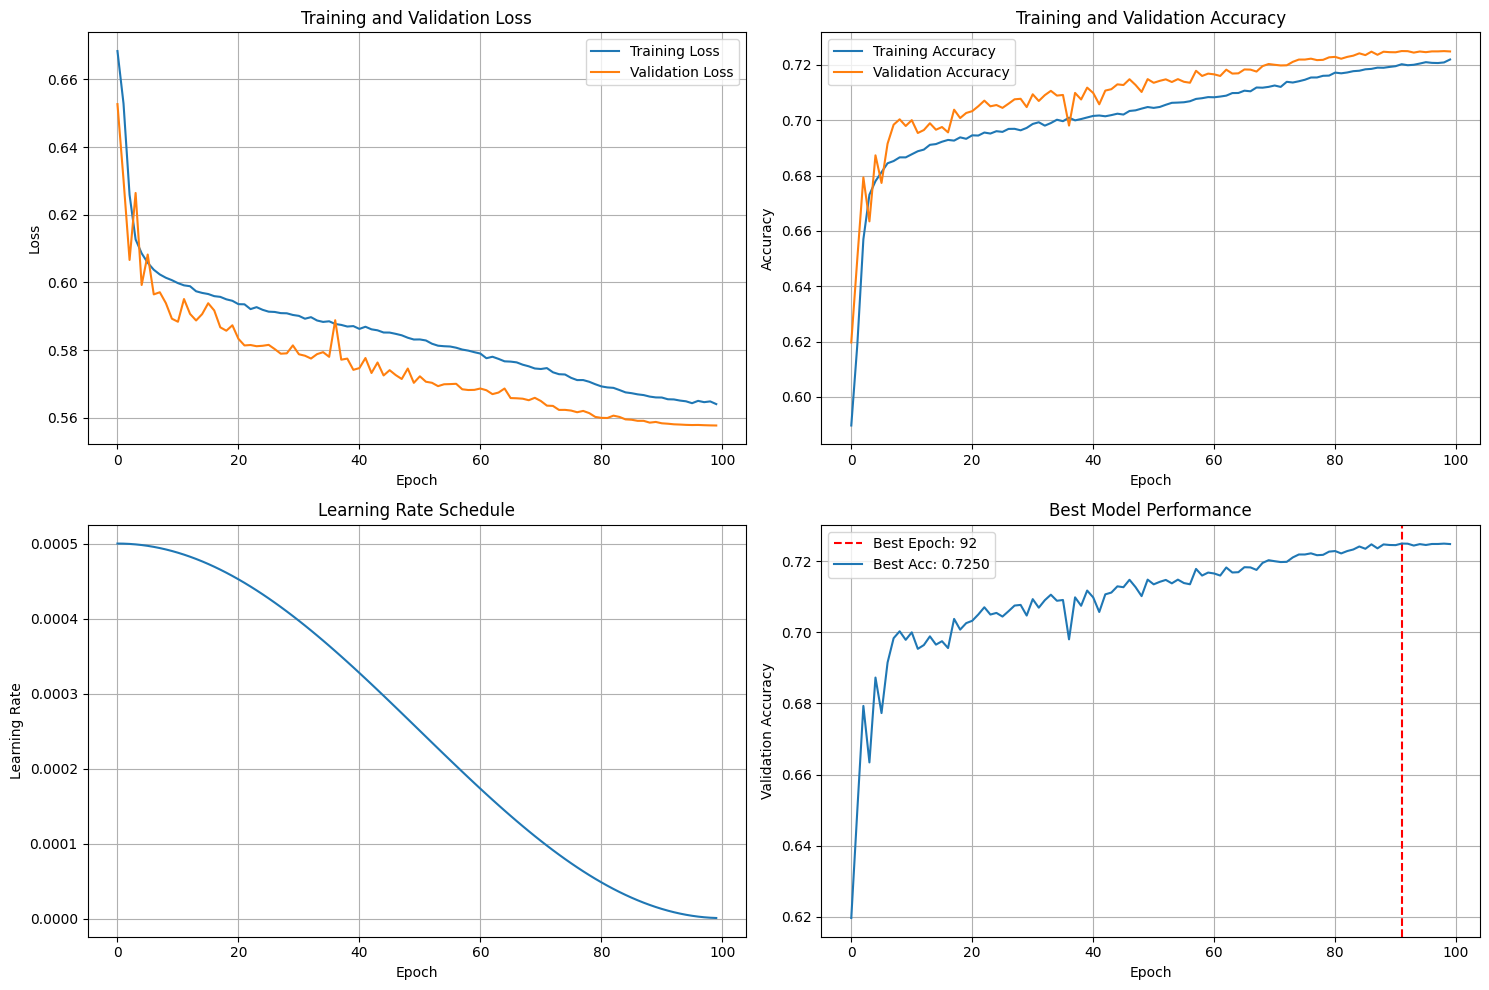

In [ ]:
#Visualizing Training Results
# I'm plotting the metrics to analyze model performance
plt.figure(figsize=(15, 10))
# Plotting training and validation loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
# Plotting training and validation accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
# Plotting learning rate
plt.subplot(2, 2, 3)
plt.plot(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
# Calculating epoch with best validation accuracy
best_epoch = np.argmax(val_accuracies)
plt.subplot(2, 2, 4)
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_epoch+1}')
plt.plot(val_accuracies, label=f'Best Acc: {val_accuracies[best_epoch]:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Best Model Performance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_results.png')
plt.show()

Validation:  62%|██████▏   | 8/13 [00:00<00:00, 38.84it/s, val_loss=0.5573, val_acc=0.7258]

Validation: 100%|██████████| 13/13 [00:00<00:00, 22.71it/s, val_loss=0.5666, val_acc=0.7255]


Test set - Loss: 0.5555, Accuracy: 0.7255


Computing confusion matrix: 100%|██████████| 13/13 [00:00<00:00, 31.64it/s]



Confusion Matrix:
True Positives: 8692
True Negatives: 9372
False Positives: 3034
False Negatives: 3802

Metrics:
Accuracy: 0.7255
Precision: 0.7413
Recall (Sensitivity): 0.6957
Specificity: 0.7554
F1 Score: 0.7178


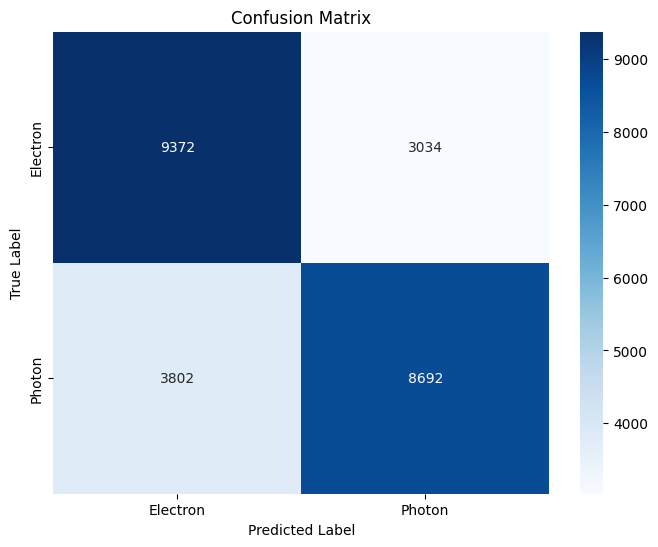

In [ ]:

# Evaluating on Test Set
# I'm loading the best model and evaluating on the test set
import seaborn as sns
particle_model.load_state_dict(torch.load(best_model_path))
particle_model.eval()
# Evaluating on test set
test_loss, test_acc = validate(particle_model, test_loader, criterion, device)
print(f"Test set - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
# Calculating confusion matrix
def compute_confusion_matrix(model, loader, device):
    """Compute confusion matrix for binary classification"""
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Computing confusion matrix"):
            inputs = inputs.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            targets = targets.to(device)
            
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    
    # Computing confusion matrix values
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    return tp, tn, fp, fn
tp, tn, fp, fn = compute_confusion_matrix(particle_model, test_loader, device)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
print("\nConfusion Matrix:")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print("\nMetrics:")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")
plt.figure(figsize=(8, 6))
cm = np.array([[tn, fp], [fn, tp]])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Electron', 'Photon'],
            yticklabels=['Electron', 'Photon'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

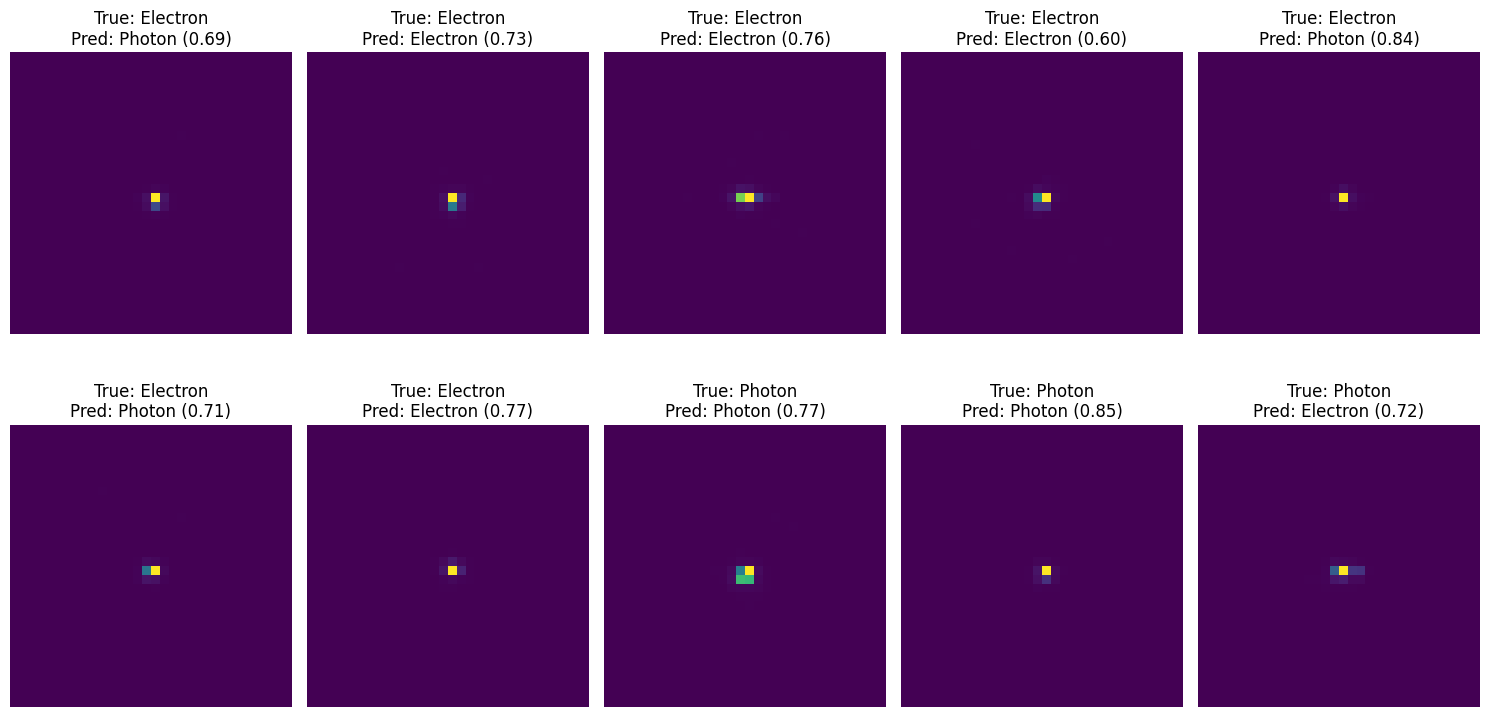

In [16]:
# Visualize Predictions on Random Samples
# I'm visualizing model predictions on random test samples
def get_random_samples(loader, num_samples=10):
    """Get random samples from a dataloader"""
    all_inputs = []
    all_targets = []
    
    for inputs, targets in loader:
        all_inputs.append(inputs)
        all_targets.append(targets)
        if len(all_inputs) * inputs.shape[0] >= num_samples:
            break
    
    all_inputs = torch.cat(all_inputs)
    all_targets = torch.cat(all_targets)
    
    indices = np.random.choice(len(all_inputs), num_samples, replace=False)
    return all_inputs[indices], all_targets[indices]
# Getting random samples
num_samples = 10
random_inputs, random_targets = get_random_samples(test_loader, num_samples)
# Making predictions
particle_model.eval()
with torch.no_grad():
    inputs = random_inputs.to(device)
    inputs = inputs.permute(0, 3, 1, 2)
    outputs = particle_model(inputs)
    probabilities = torch.sigmoid(outputs).cpu().numpy().flatten()
    predictions = (probabilities > 0.5).astype(int)
    targets = random_targets.cpu().numpy().flatten()
# Visualizing predictions
plt.figure(figsize=(15, 8))
for i in range(num_samples):
    plt.subplot(2, 5, i+1)
    # Showing channel 0 of the image
    plt.imshow(normalize_for_display(random_inputs[i, :, :, 0].numpy()), cmap='viridis')
    
    # Adding color border based on correctness
    correct = predictions[i] == targets[i]
    border_color = 'green' if correct else 'red'
    plt.gca().spines['bottom'].set_color(border_color)
    plt.gca().spines['top'].set_color(border_color) 
    plt.gca().spines['right'].set_color(border_color)
    plt.gca().spines['left'].set_color(border_color)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['top'].set_linewidth(2) 
    plt.gca().spines['right'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    
    # Adding prediction info as title
    true_class = 'Photon' if targets[i] == 1 else 'Electron'
    pred_class = 'Photon' if predictions[i] == 1 else 'Electron'
    conf = probabilities[i] if predictions[i] == 1 else 1 - probabilities[i]
    plt.title(f"True: {true_class}\nPred: {pred_class} ({conf:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.savefig('prediction_samples.png')
plt.show()

Analyzing model performance by image intensity...


Analyzing performance by intensity: 100%|██████████| 13/13 [00:00<00:00, 22.01it/s]


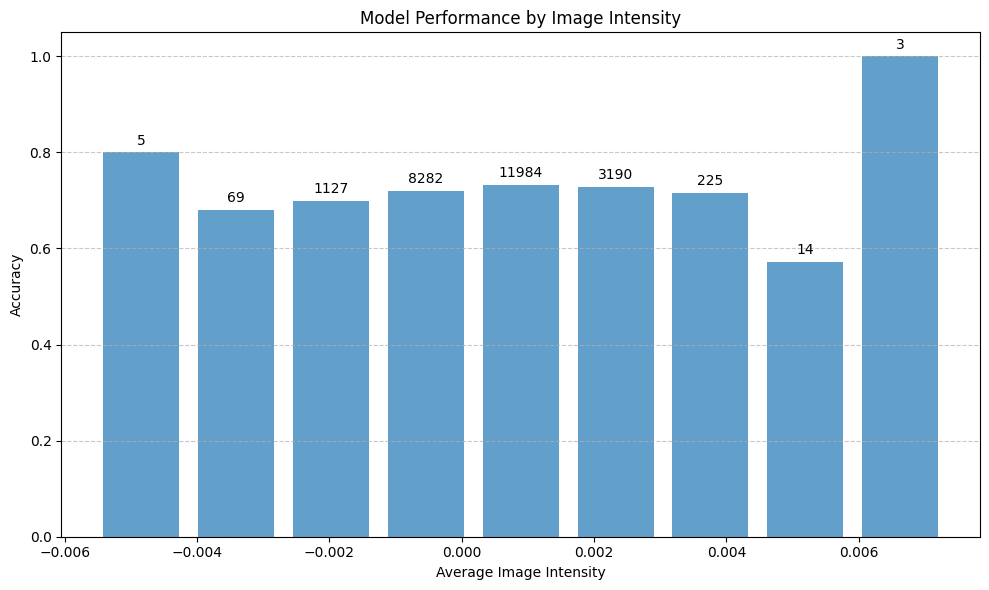

In [17]:
# Model Performance on Different Energy Regions
# I'm analyzing how model performance varies across different image intensity regions
# This helps understand where the model might be struggling
def analyze_performance_by_intensity(model, loader, device):
    """Analyze model performance across different image intensity ranges"""
    model.eval()
    
    # Initializing storage for results
    all_intensities = []
    all_correct = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Analyzing performance by intensity"):
            # Calculating average intensity of each image (across both channels)
            intensities = inputs.mean(dim=(1, 2, 3)).cpu().numpy()
            
            # Getting predictions
            inputs = inputs.to(device)
            inputs = inputs.permute(0, 3, 1, 2)
            targets = targets.to(device)
            
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            
            # Recording which predictions were correct
            correct = (predictions == targets).cpu().numpy().flatten()
            
            # Storing results
            all_intensities.extend(intensities)
            all_correct.extend(correct)
    
    # Converting to numpy arrays
    all_intensities = np.array(all_intensities)
    all_correct = np.array(all_correct)
    
    # Creating intensity bins
    bins = np.linspace(np.min(all_intensities), np.max(all_intensities), 10)
    bin_indices = np.digitize(all_intensities, bins) - 1
    
    # Calculating accuracy for each bin
    bin_accuracies = []
    bin_counts = []
    bin_centers = []
    
    for i in range(len(bins)-1):
        mask = bin_indices == i
        bin_accuracy = all_correct[mask].mean() if np.any(mask) else 0
        bin_count = np.sum(mask)
        bin_center = (bins[i] + bins[i+1]) / 2
        
        bin_accuracies.append(bin_accuracy)
        bin_counts.append(bin_count)
        bin_centers.append(bin_center)
    
    return bin_centers, bin_accuracies, bin_counts
# Running analysis
print("Analyzing model performance by image intensity...")
bin_centers, bin_accuracies, bin_counts = analyze_performance_by_intensity(
    particle_model, test_loader, device)
# Plotting results
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, bin_accuracies, width=(bin_centers[1]-bin_centers[0])*0.8, alpha=0.7)
plt.xlabel('Average Image Intensity')
plt.ylabel('Accuracy')
plt.title('Model Performance by Image Intensity')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# Adding sample counts
for i, (center, acc, count) in enumerate(zip(bin_centers, bin_accuracies, bin_counts)):
    plt.text(center, acc + 0.01, f"{count}", ha='center', va='bottom')
plt.tight_layout()
plt.savefig('performance_by_intensity.png')
plt.show()

Visualizing feature maps...


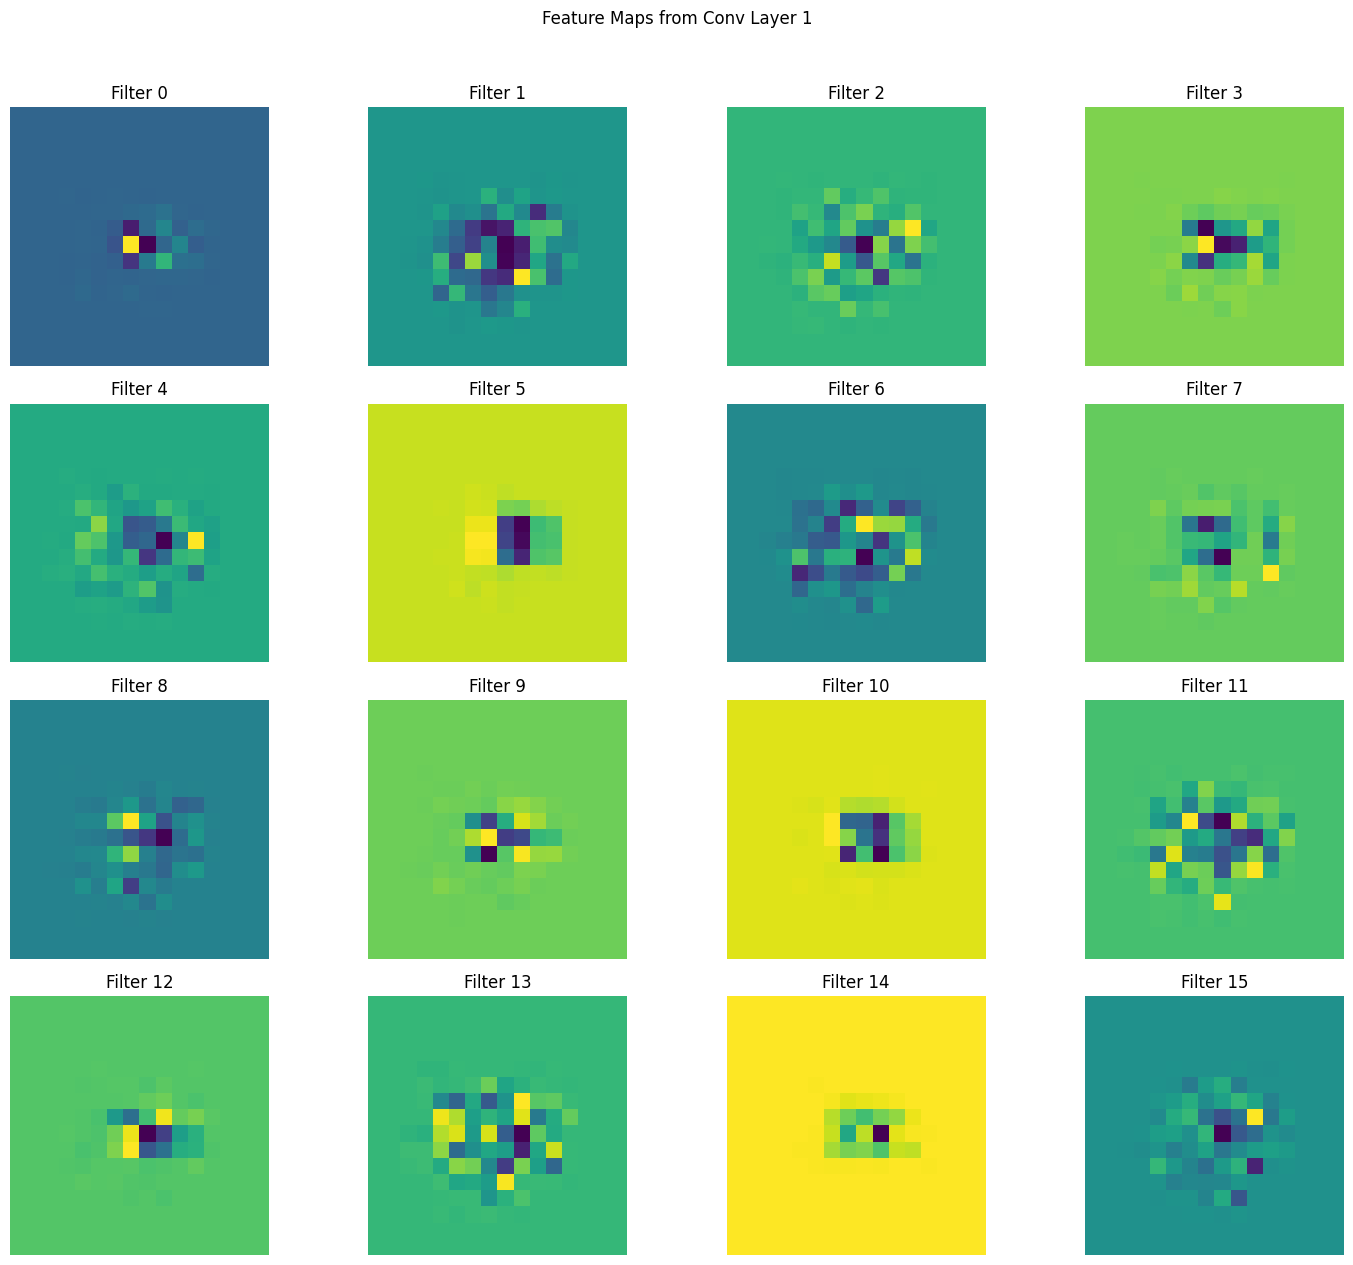

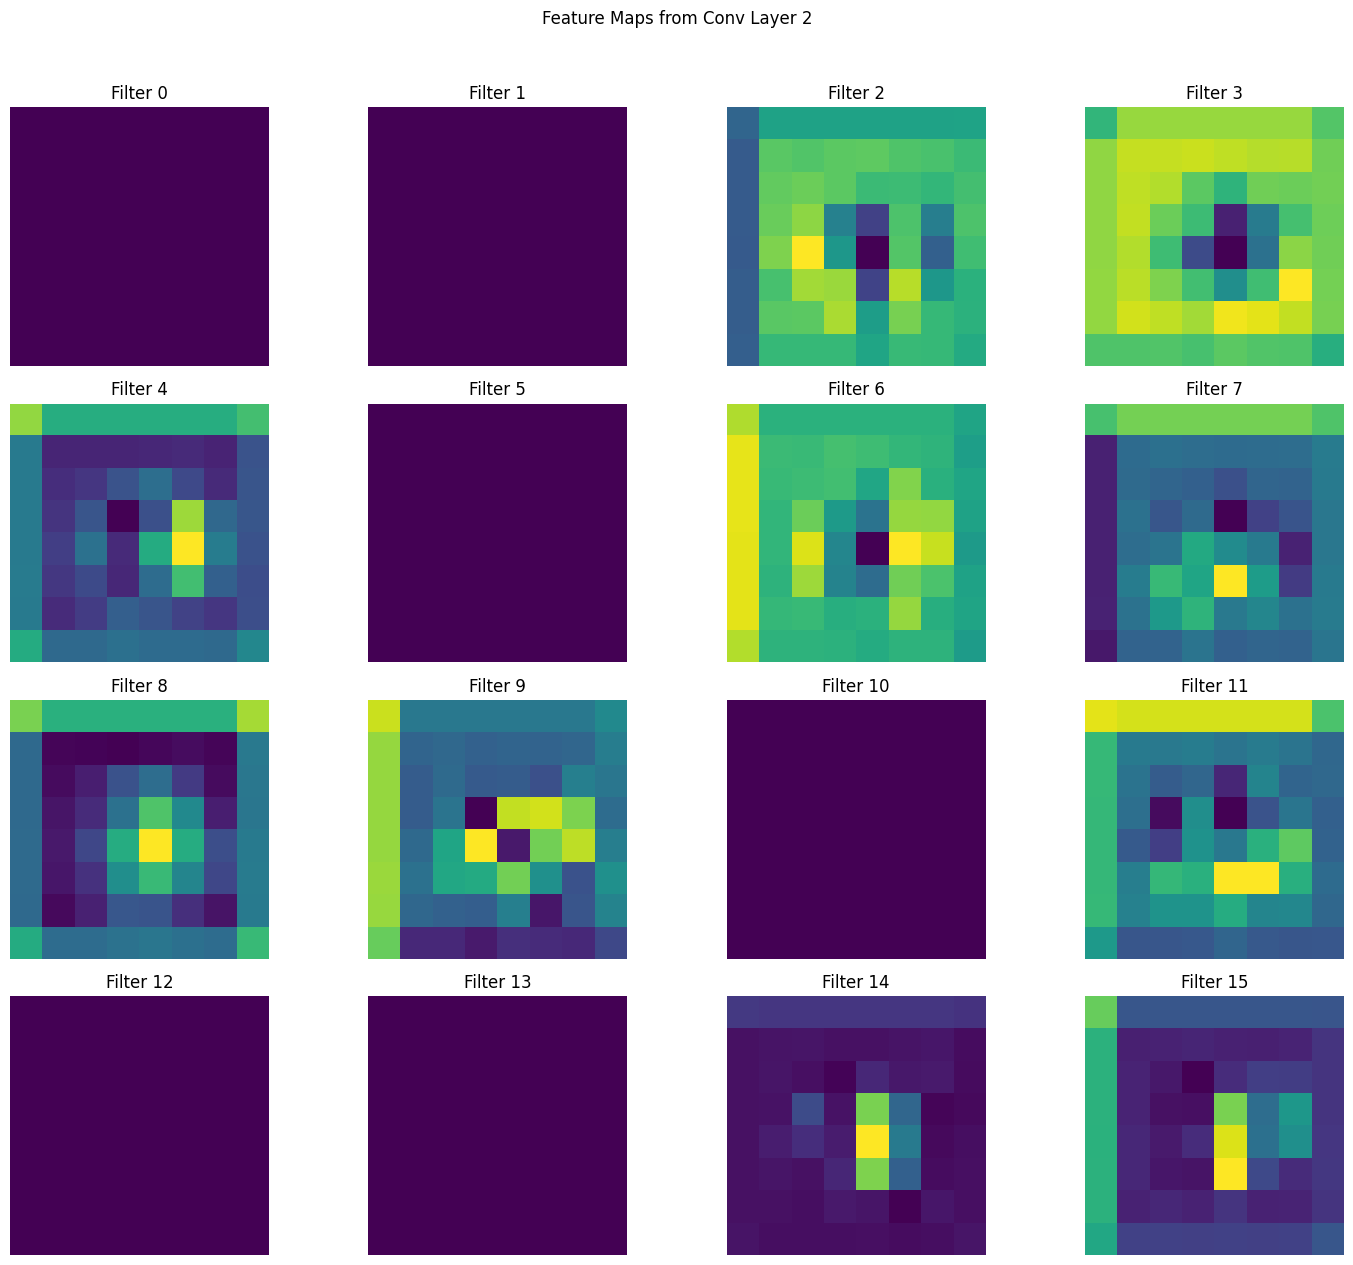

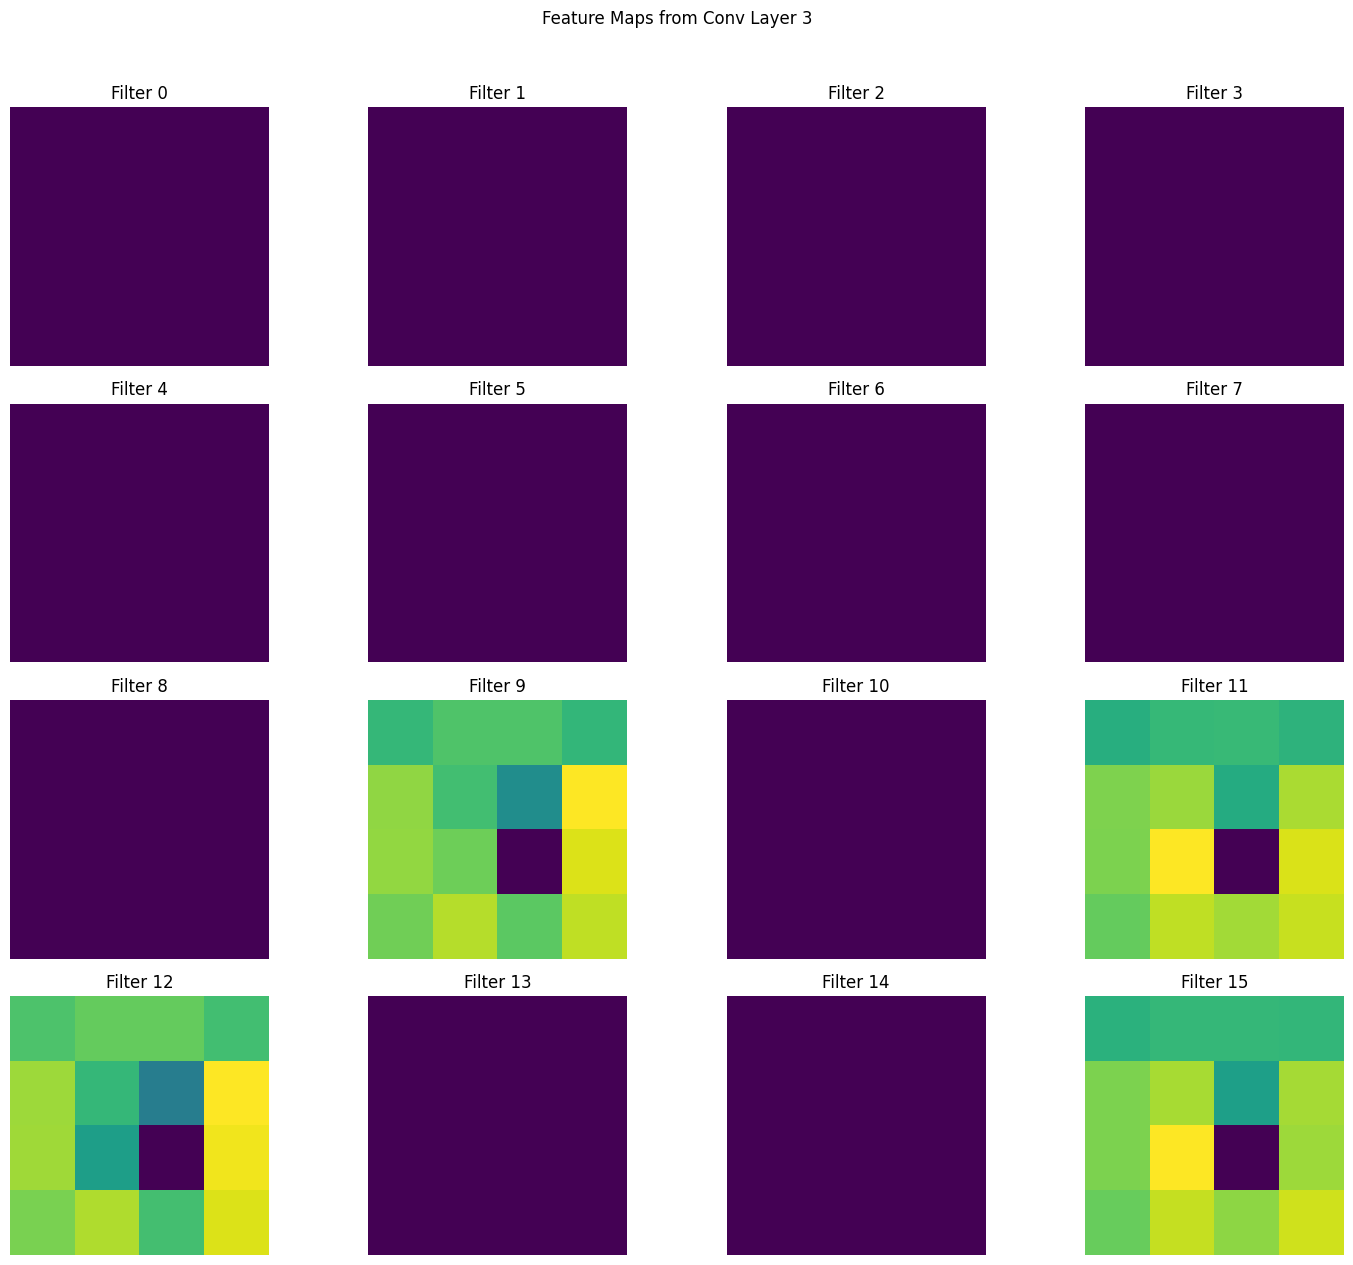

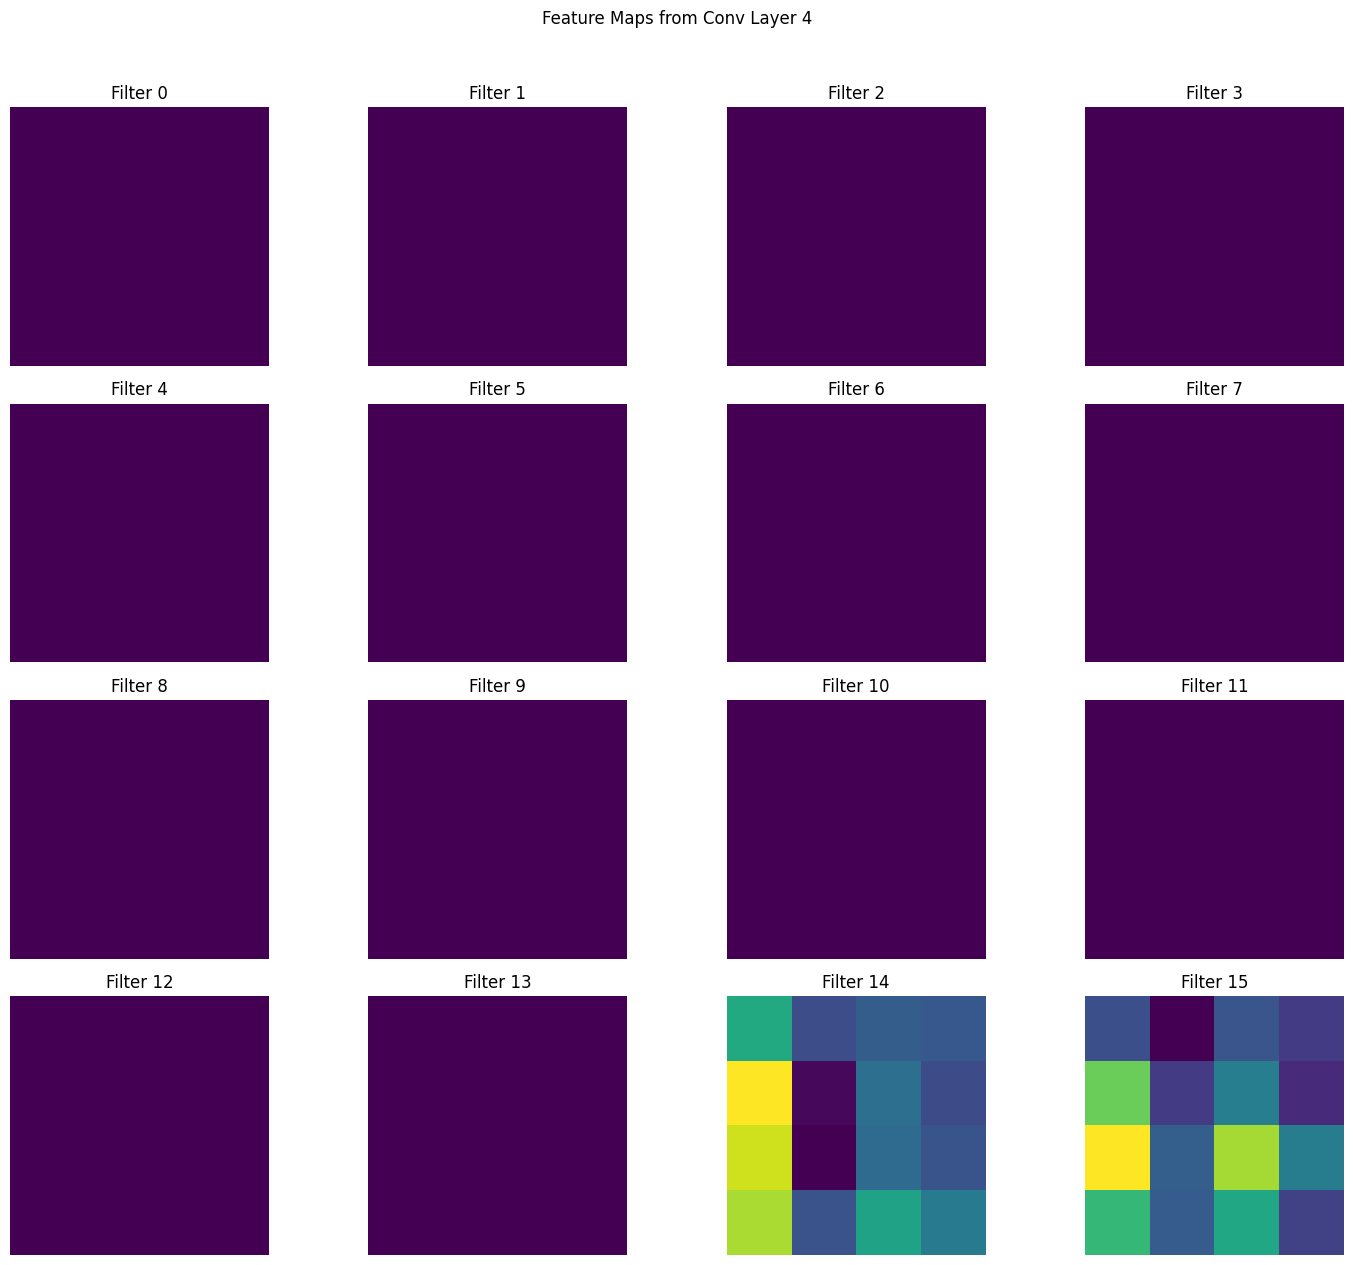

In [18]:
# Feature Maps Visualization
# I'm visualizing the feature maps to better understand what the model has learned
def visualize_feature_maps(model, sample_input, layer_index=1):
    """Visualize feature maps from convolutional layers"""
    model_copy = ParticleClassifier()
    model_copy.load_state_dict(model.state_dict())
    model_copy.eval()
    model_copy.to(device) 
    # Defining forward hook to extract feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach().cpu().numpy()
        return hook
    
    # Registering hook to the desired layer
    if layer_index == 1:
        model_copy.conv1.conv.register_forward_hook(get_activation('conv1'))
    elif layer_index == 2:
        model_copy.conv2.conv.register_forward_hook(get_activation('conv2'))
    elif layer_index == 3:
        model_copy.conv3.conv.register_forward_hook(get_activation('conv3'))
    elif layer_index == 4:
        model_copy.conv4.conv.register_forward_hook(get_activation('conv4'))
    
    # Forward pass with sample input
    input_tensor = sample_input.unsqueeze(0).to(device)
    input_tensor = input_tensor.permute(0, 3, 1, 2)
    with torch.no_grad():
        output = model_copy(input_tensor)
    
    # Get activation from the specified layer
    layer_name = f'conv{layer_index}'
    feature_maps = activation[layer_name]
    
    # Determine number of feature maps to display
    num_features = min(16, feature_maps.shape[1])
    
    # Create subplot grid
    rows = int(np.ceil(num_features / 4))
    plt.figure(figsize=(15, 3 * rows))
    
    # Plotting each feature map
    for i in range(num_features):
        plt.subplot(rows, 4, i + 1)
        feature_map = feature_maps[0, i]
        plt.imshow(feature_map, cmap='viridis')
        plt.title(f'Filter {i}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f'Feature Maps from Conv Layer {layer_index}', y=1.05)
    plt.savefig(f'feature_maps_layer{layer_index}.png')
    plt.show()
# Getting a sample from test data
random_idx = np.random.randint(0, len(test_dataset))
sample_input, sample_target = test_dataset[random_idx]
# Visualizing feature maps from each convolutional layer
print("Visualizing feature maps...")
for layer_idx in range(1, 5):
    visualize_feature_maps(particle_model, sample_input, layer_idx)


In [19]:
#Training Summary and Final Model Information
# I'm providing a final summary of the entire training process
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
# Displaying model architecture and parameters one more time
display_model_summary(particle_model)
# Training duration and results
print("\nTraining Details:")
print(f"Number of epochs: {num_epochs}")
print(f"Best validation accuracy: {best_val_acc:.4f} (Epoch {np.argmax(val_accuracies)+1})")
print(f"Final test accuracy: {test_acc:.4f}")
# Dataset information
print("\nDataset Information:")
print(f"Total samples: {len(combined_images)}")
print(f"Training samples: {len(train_dataset)} ({len(train_dataset)/len(combined_images)*100:.1f}%)")
print(f"Validation samples: {len(val_dataset)} ({len(val_dataset)/len(combined_images)*100:.1f}%)")
print(f"Test samples: {len(test_dataset)} ({len(test_dataset)/len(combined_images)*100:.1f}%)")
print(f"Image dimensions: {combined_images.shape[1:]} (H, W, C)")
# Model saved locations
print("\nSaved Models:")
print(f"Best model: {best_model_path}")
print("Checkpoints:", end="")
for epoch in range(10, num_epochs+1, 10):
    checkpoint_path = os.path.join(save_dir, f"particle_classifier_epoch_{epoch}.pth")
    if os.path.exists(checkpoint_path):
        print(f" Epoch {epoch},", end="")
print("\n")
# Performance metrics
print("Performance Metrics:")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")
# Training configuration
print("\nTraining Configuration:")
print(f"Learning rate: {learning_rate}")
print(f"Batch size: {batch_size}")
print(f"Weight decay: {weight_decay}")
print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Scheduler: {scheduler.__class__.__name__}")
print(f"Device: {device}")
print("\n" + "="*50)
print("End of common task :)")
print("="*50)


TRAINING SUMMARY
Model Architecture:
ParticleClassifier(
  (conv1): ConvBlock(
    (conv): Conv2d(2, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (conv4): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(